In [1]:
from cmb.configs.experiments import Configs
from cmb.datasets.jetclass import SampleCoupling
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Configs('epic_mixed.yaml')
jets = SampleCoupling(config=config.data, standardize=False)
dynamics = ConditionalFlowMatching(config)


2024-09-22 23:48:23.919587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 23:48:23.964560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 23:48:23.965549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 23:48:24.636174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


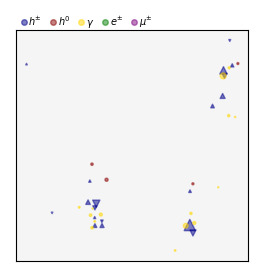

In [6]:
jets.target.display_cloud(10, 100)

In [14]:
jets.target.flavor[10], jets.target.isChargedHadron[10], jets.target.isNeutralHadron[10], jets.target.isPhoton[10]

(tensor([0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 2, 1, 0, 2,
         2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [74]:
import torch

a = torch.cat([jets.target.isPhoton.unsqueeze(1),
               jets.target.isNeutralHadron.unsqueeze(1),
               jets.target.isChargedHadron.unsqueeze(1) * jets.target.charge.unsqueeze(1),
               jets.target.isElectron.unsqueeze(1) * jets.target.charge.unsqueeze(1),
               jets.target.isMuon.unsqueeze(1) * jets.target.charge.unsqueeze(1),
               ], dim=1).permute(0,2,1).long()

In [75]:
import torch

def combine_type_charge_by_multiplying(type_one_hot, charge):
    """
    Combines one-hot encoded 'type' and 'charge' by multiplying them together,
    resulting in a tensor with entries in [-1, 0, 1].

    Args:
    - type_one_hot (torch.Tensor): A tensor of shape (b, n, 5) with one-hot encoded types.
    - charge (torch.Tensor): A tensor of shape (b, n) with 'charge' values (-1, 0, 1).

    Returns:
    - torch.Tensor: A tensor of shape (b, n, 5) where values are -1, 0, or 1.
    """
    # Reshape charge to match one-hot dimensions and multiply
    charge_expanded = charge.unsqueeze(-1)  # shape (b, n, 1)
    combined = type_one_hot * charge_expanded  # shape (b, n, 5)

    return combined

def extract_labels_from_combined(combined):
    """
    Extracts the type index and charge from the combined tensor.

    Args:
    - combined (torch.Tensor): A tensor of shape (b, n, 5) where values are -1, 0, or 1.

    Returns:
    - torch.Tensor: A tensor of shape (b, n) with type indices (0 to 4).
    - torch.Tensor: A tensor of shape (b, n) with charge values (-1, 0, 1).
    """
    # Extract the argmax and argmin
    argmax = torch.argmax(combined, dim=-1)  # Get the index of the +1 entry
    argmin = torch.argmin(combined, dim=-1)  # Get the index of the -1 entry

    # Check for ambiguous case where the max value is 0 (neutral type)
    # If all entries are <= 0, argmax returns index 0 even for neutral cases
    max_values, _ = torch.max(combined, dim=-1)
    min_values, _ = torch.min(combined, dim=-1)

    # If max value is 0, it means the type is neutral
    type_index = torch.where(max_values > 0, argmax, argmin)
    
    # Assign charge based on whether max_values or min_values is >0
    charge = torch.where(max_values > 0, torch.tensor(1), torch.tensor(-1))
    charge = torch.where(max_values == 0, torch.tensor(0), charge)  # Neutral type case

    return type_index, charge

def decompose_type_charge_to_onehot(type_index, charge):
    one_hot_shape = (*type_index.shape, 5)
    type_one_hot = torch.zeros(one_hot_shape, dtype=torch.int64)
    type_one_hot.scatter_(-1, type_index.unsqueeze(-1), 1)
    
    return type_one_hot, charge

In [81]:
b = extract_labels_from_combined(a)

In [84]:
a[0].shape

torch.Size([128, 5])

In [86]:
torch.argmax(a, dim=-1) [0]

tensor([1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0,
        0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [87]:
a[0]

tensor([[ 0,  1,  0,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  1,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 0,  1,  0,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 0,  1,  0,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0],
        [ 

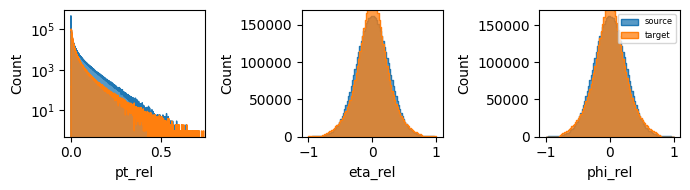

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2))
jets.source.histplot('pt_rel', ax=ax[0], log_scale=(False,True))
jets.target.histplot('pt_rel', ax=ax[0], log_scale=(False,True))
jets.source.histplot('eta_rel', binrange=(-1,1), binwidth=0.02, ax=ax[1])
jets.target.histplot('eta_rel', binrange=(-1,1), binwidth=0.02,ax=ax[1])
jets.source.histplot('phi_rel', binrange=(-1,1), binwidth=0.02,ax=ax[2], label='source')
jets.target.histplot('phi_rel',binrange=(-1,1), binwidth=0.02, ax=ax[2], label='target')
ax[2].legend(fontsize=6)
plt.tight_layout()
plt.show()

(None, None)

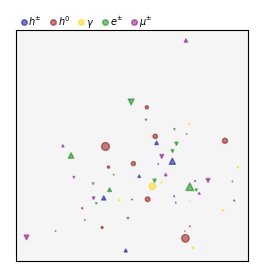

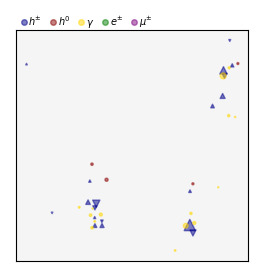

In [3]:
jets.source.display_cloud(idx=10,  scale_marker=100.0), jets.target.display_cloud(idx=10,  scale_marker=100.0)

In [18]:
import torch
from torch import nn

from cmb.models.architectures.epic import EPiC

class HybridEPiC(nn.Module):
    ''' MLP architecture for hybrid continuous-discrete models
    '''
    def __init__(self, config):
        super().__init__()
        self.dim_features_continuous = config.data.dim.features.continuous
        self.dim_features_discrete = config.data.dim.features.discrete
        self.vocab_size = config.data.vocab_size.features
        
        self.epic = EPiC(config)

    def forward(self, t, x, k, context_continuous=None, context_discrete=None, mask=None):
        h = self.mlp(t, x, k, context_continuous, context_discrete, mask)
        continuous_head = h[:, :self.dim_features_continuous]
        discrete_head = h[:, self.dim_features_continuous:]
        logits = discrete_head.reshape(k.size(0), self.dim_features_discrete, self.vocab_size)
        return continuous_head, logits
    

In [19]:
import torch 
from dataclasses import dataclass
from torch.nn import MSELoss, CrossEntropyLoss
from torch.distributions import Categorical 

from cmb.dynamics.utils import OTPlanSampler
from cmb.dynamics.processes import TelegraphProcess

class ConditionalMarkovBridge :
    ''' Conditional Markov Bridge base class
    '''
    def __init__(self, config: dataclass):

        self.config = config.dynamics
        self.vocab_size = config.data.vocab_size.features

        self.ref_process = TelegraphProcess(config)
        self.loss_continuous_fn = MSELoss(reduction='sum')
        self.loss_discrete_fn = CrossEntropyLoss(reduction='sum')
    
    def sample_coupling(self, batch):
        """ conditional variable z = (x_0, x1) ~ pi(x_0, x_1)
        """		
        self.x0 = batch.source_continuous
        self.x1 = batch.target_continuous
        self.k0 = batch.source_discrete
        self.k1 = batch.target_discrete
        self.context_continuous = batch.target_context_continuous if hasattr(batch, 'target_context_continuous') else None
        self.context_discrete = batch.target_context_discrete if hasattr(batch, 'target_context_discrete') else None
        self.mask = batch.target_mask if hasattr(batch, 'target_mask') else torch.ones_like(self.x0[..., 0]).unsqueeze(-1)

    def sample_time(self):
        """ sample time: t ~ U[0,1]
        """
        t = torch.rand(self.x1.shape[0], device=self.x1.device).type_as(self.x1)
        self.t = self.reshape_time(t, self.x1)

    def sample_bridge(self):
        """ sample continuous features from gaussian probability path: x_t ~ p_t(x|x_0, x_1)
        """
        #...continuous:
        mean = self.t * self.x1 + (1. - self.t) * self.x0
        std = self.config.sigma
        self.bridge_continuous = mean + std * torch.randn_like(mean)
	
        #...discrete:        
        k = torch.arange(0, self.vocab_size)
        if self.k0.dim() == 1: self.k0 = self.k0.unsqueeze(1)  # Add an extra dimension if needed
        if self.k1.dim() == 1: self.k1 = self.k1.unsqueeze(1)

        k = k[None, None, :].repeat(self.k0.size(0), self.k0.size(1), 1).float()
        k = k.to(self.k0.device)

        print(k.shape, self.k1.shape, self.k0.shape, self.t.shape)
        transition_probs = self.ref_process.bridge_probability(k, self.k1, self.k0, self.t.squeeze())
        self.bridge_discrete = Categorical(transition_probs).sample().to(self.k1.device)

    def get_drift(self):
        """ conditional drift u_t(x|x_0,x_1)
        """
        A = 0.
        B = 1.
        C = -1.
        self.drift = A * self.bridge_continuous + B * self.x1 + C * self.x0

    def loss(self, model, batch):
        """ conditional flow-mathcing MSE loss + jump-matching CE loss
        """
        self.sample_coupling(batch)
        self.sample_time() 
        self.sample_bridge()
        self.get_drift()

        vt, logits = model(t=self.t, 
                           x=self.bridge_continuous, 
                           k=self.bridge_discrete, 
                           context_continuous=self.context_continuous, 
                           context_discrete=self.context_discrete, 
                           mask=self.mask,                    
                           output_rates=False)
        
        logits = logits.reshape(-1, self.vocab_size)
        targets = self.k1.reshape(-1).long()
        targets = targets.to(logits.device)
        ut = self.drift.to(vt.device)
        loss = self.loss_continuous_fn(vt, ut) + self.config.lam * self.loss_discrete_fn(logits, targets)

        return loss / self.mask.sum()

    def reshape_time(self, t, x):
        if isinstance(t, (float, int)): return t
        else: return t.reshape(-1, *([1] * (x.dim() - 1)))

class OTCMB(ConditionalMarkovBridge):
    def sample_coupling(self, batch):
        OT = OTPlanSampler()	
        self.x0 = batch.source_continuous
        self.x1 = batch.target_continuous
        self.k0 = batch.source_discrete
        self.k1 = batch.target_discrete
        pi = OT.get_map(self.x0, self.x1)
        idx_0, idx_1 = OT.sample_map(pi, self.x0.shape[0], replace=False)
        self.x0, self.x1 = self.x0[idx_0], self.x1[idx_1]
        self.k0, self.k1 = self.k0[idx_0], self.k1[idx_1]
        self.context_continuous = batch.target_context_continuous if hasattr(batch, 'target_context_continuous') else None
        self.context_discrete = batch.target_context_discrete if hasattr(batch, 'target_context_discrete') else None
        self.mask = batch.target_mask if hasattr(batch, 'target_mask') else torch.ones_like(self.x0[..., 0]).unsqueeze(-1)


class SBCMB(ConditionalMarkovBridge):
    def sample_coupling(self, batch):
        regulator = 2 * self.config.sigma**2
        SB = OTPlanSampler(reg=regulator)	
        self.x0 = batch.source_continuous
        self.x1 = batch.target_continuous
        self.k0 = batch.source_discrete
        self.k1 = batch.target_discrete
        pi = SB.get_map(self.x0, self.x1)
        idx_0, idx_1 = SB.sample_map(pi, self.x0.shape[0], replace=False)
        self.x0, self.x1 = self.x0[idx_0], self.x1[idx_1]
        self.k0, self.k1 = self.k0[idx_0], self.k1[idx_1]
        self.context_continuous = batch.target_context_continuous if hasattr(batch, 'target_context_continuous') else None
        self.context_discrete = batch.target_context_discrete if hasattr(batch, 'target_context_discrete') else None
        self.mask = batch.target_mask if hasattr(batch, 'target_mask') else torch.ones_like(self.x0[..., 0]).unsqueeze(-1)

    def sample_continuous_bridge(self):
        self.mean = self.t * self.x1 + (1 - self.t) * self.x0
        std = self.config.sigma * torch.sqrt(self.t * (1 - self.t))
        self.continuous_bridge = self.mean + std * torch.randn_like(self.mean)
		
    def get_drift(self):
        """ conditional drift u_t(x|x_0,x_1)
        """
        A = (1 - 2 * self.t) / ( self.t * (1 - self.t))
        B = self.t**2 / ( self.t * (1 - self.t))
        C = -1 * (1 - self.t)**2 / ( self.t * (1 - self.t))

        self.drift = A * self.continuous_bridge + B * self.x1 + C * self.x0

In [44]:
jets.target.discrete[10]

tensor([[ 0., -1.],
        [ 0., -1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 2.,  0.],
        [ 0.,  1.],
        [ 0., -1.],
        [ 2.,  0.],
        [ 0., -1.],
        [ 0.,  1.],
        [ 0., -1.],
        [ 0., -1.],
        [ 0., -1.],
        [ 0., -1.],
        [ 0.,  0.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 0., -1.],
        [ 2.,  0.],
        [ 0.,  1.],
        [ 2.,  0.],
        [ 0.,  0.],
        [ 0., -1.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 0., -1.],
        [ 2.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  1.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 0., -1.],
        [ 0.,  1.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],


In [33]:
(jets.target.discrete[..., 1]>0)[0]

tensor([False, False, False, False, False,  True,  True,  True, False, False,
        False, False, False, False, False,  True, False,  True, False, False,
         True, False,  True, False, False, False,  True, False, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False,  True, False, False,  True,  True, False, False, False, False,
        False,  True, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

In [30]:
jets.target.discrete[..., 1] < 0 

tensor([[False, False,  True,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [ True,  True, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False,  True,  True,  ..., False, False, False]])

In [10]:
from cmb.models.trainers import CMBTrainer
# from cmb.dynamics.cmb import ConditionalMarkovBridge
epic = HybridEPiC(config)
dynamics = ConditionalMarkovBridge(config)
model = CMBTrainer(config, dynamics, epic, jets)
model.train()


number of training parameters: 503778
number of training parameters: 503778
start training...
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


epochs:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([1024, 128, 8]) torch.Size([1024, 128, 2]) torch.Size([1024, 128, 2]) torch.Size([1024, 1, 1])


RuntimeError: The size of tensor a (2) must match the size of tensor b (8) at non-singleton dimension 2

In [4]:
from cmb.models.pipelines import Pipeline
num_gen_jets = 3000
pipeline = Pipeline(trained_model=generative_model, config=config)
test = CouplingData(config.data)
pipeline.generate_samples(source_continuous=test.source.continuous[:num_gen_jets], mask=test.source.mask[:num_gen_jets])

In [5]:
from cmb.data.jetclass import ParticleClouds

generated = torch.cat([pipeline.paths[-1], test.source.mask[:num_gen_jets]], dim=-1)
jets_generated = ParticleClouds(generated) 

varying number of constituents (max. 128)

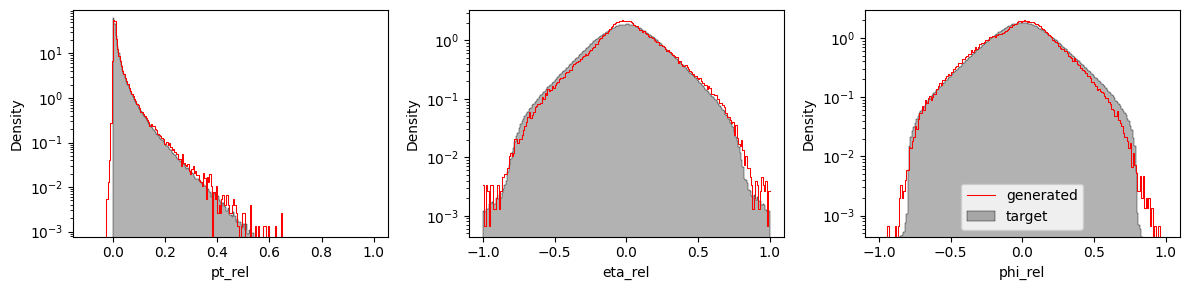

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel',binrange=(-1, 1), binwidth=0.01, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()

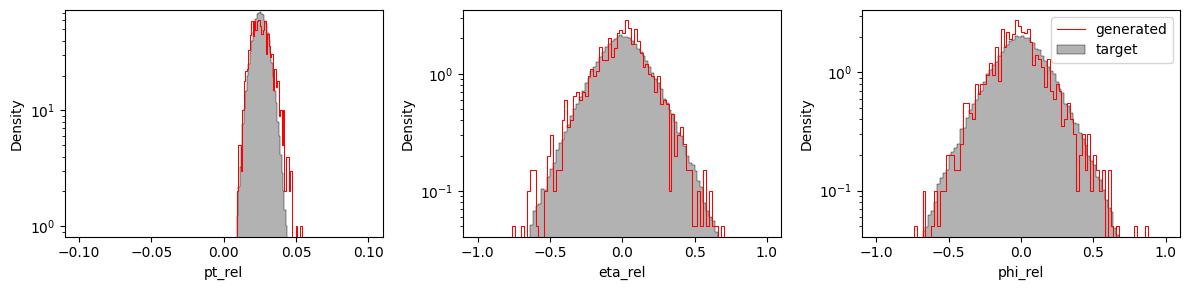

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', idx=10, binrange=(-.1, .1), binwidth=0.001, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=10, binrange=(-.1, .1), binwidth=0.001, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=10,  binrange=(-1, 1), binwidth=0.02, ax=ax[1],  log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[2],log_scale=(False, True),  color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()

In [1]:
n=102
fig, ax = plt.subplots(1,3, figsize=(6,2))
jets.source.display_cloud(idx=n, scale_marker=100, ax=ax[0], color='darkblue')
jets_generated.display_cloud(idx=n, scale_marker=100, ax=ax[1], color='gold')
jets.target.display_cloud(idx=n, scale_marker=100, ax=ax[2], color='darkred')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined